In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from utils import load_inp_outp, create_network_df, prepare_network_data, load_inp_outp_cap
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from efficient_kan import KAN
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pickle
import os

In [3]:
pwd = os.path.join(os.getcwd())
directory_sioux = pwd + "/data/sioux/uncongested"
directory_ema = pwd + "/data/EMA/uncongested"
directory_sample = pwd + "/data/sample"

# Linear Regression

## Part 1: fixed capacities and free-flow times

In [4]:
OD_sioux, target_flows_sioux = load_inp_outp(directory_sioux)
X_sioux = OD_sioux.reshape(OD_sioux.shape[0], -1)
nonzero_indices = np.nonzero(target_flows_sioux[0])
y_sioux = target_flows_sioux[:, nonzero_indices[0], nonzero_indices[1]]
OD_ema, target_flows_ema = load_inp_outp(directory_ema)
X_ema = OD_ema.reshape(OD_ema.shape[0], -1)
nonzero_indices = np.nonzero(target_flows_ema[0])
y_ema = target_flows_ema[:, nonzero_indices[0], nonzero_indices[1]]

In [5]:
scaler_X_sioux = StandardScaler()
X_scaled_sioux = scaler_X_sioux.fit_transform(X_sioux)

scaler_y_sioux = StandardScaler()
y_scaled_sioux = scaler_y_sioux.fit_transform(y_sioux)

X_train_sioux, X_test_sioux, y_train_sioux, y_test_sioux = train_test_split(X_scaled_sioux, y_scaled_sioux, test_size=0.1, random_state=42, shuffle=False)
model_sioux = LinearRegression()
model_sioux.fit(X_train_sioux, y_train_sioux)

scaler_X_ema = StandardScaler()
X_scaled_ema = scaler_X_ema.fit_transform(X_ema)

scaler_y_ema = StandardScaler()
y_scaled_ema = scaler_y_ema.fit_transform(y_ema)

X_train_ema, X_test_ema, y_train_ema, y_test_ema = train_test_split(X_scaled_ema, y_scaled_ema, test_size=0.1, random_state=42)
model_ema = LinearRegression()
model_ema.fit(X_train_ema, y_train_ema)

LinearRegression()

In [6]:
assert False

AssertionError: 

In [ ]:
# # nonzero_indices = np.nonzero(target_flows_sioux[0])
# # capacities_sioux = capacities_sioux[:, nonzero_indices[0], nonzero_indices[1]]
# nonzero_indices = np.nonzero(target_flows_ema[0])
# capacities_ema = capacities_ema[:, nonzero_indices[0], nonzero_indices[1]]

In [6]:
y_pred_scaled_sioux = model_sioux.predict(X_test_sioux)
y_pred_scaled_ema = model_ema.predict(X_test_ema)
# y_pred_sioux = np.minimum.reduce([scaler_y_sioux.inverse_transform(y_pred_scaled_sioux), capacities_sioux[:len(X_test_sioux)]], axis=0)
y_pred_sioux = scaler_y_sioux.inverse_transform(y_pred_scaled_sioux)
y_test_original_sioux = scaler_y_sioux.inverse_transform(y_test_sioux)
# y_pred_ema = np.minimum.reduce([scaler_y_ema.inverse_transform(y_pred_scaled_ema), capacities_ema[:len(X_test_ema)]], axis=0)
y_pred_ema = scaler_y_ema.inverse_transform(y_pred_scaled_ema)
y_test_original_ema = scaler_y_ema.inverse_transform(y_test_ema)

In [7]:
def safe_mape(y_true, y_pred):
    mask = np.abs(y_true) > 0.00001
    if np.sum(mask) == 0:
        return 0.0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

def evaluate(y_true, y_pred):
    mape_list = []
    mae_list = []
    mse_list = []
    r2_list = []
    for sample in range(y_true.shape[0]):
        true_edge = y_true[sample]
        pred_edge = y_pred[sample]
        mask = true_edge != 0
        if np.sum(mask) == 0:
            continue

        true_values = true_edge[mask]
        pred_values = pred_edge[mask]

        mape_list.append(safe_mape(true_edge, pred_edge))
        mae_list.append(mean_absolute_error(true_values, pred_values))
        mse_list.append(mean_squared_error(true_values, pred_values))
        r2_list.append(r2_score(true_values, pred_values))
    mape_list = np.array(mape_list)
    metrics = {
        'MSE': np.mean(mse_list) if mse_list else np.nan,
        'RMSE': np.sqrt(np.mean(mse_list)) if mse_list else np.nan,
        'MAE': np.mean(mae_list) if mae_list else np.nan,
        'R2': np.mean(r2_list) if r2_list else np.nan,
        'MAPE': np.mean(mape_list[np.abs(mape_list) < 1]),
        'MedianAE': np.median(mae_list) if mae_list else np.nan
    }
    return metrics

In [8]:
metrics_sioux = evaluate(y_test_original_sioux, y_pred_sioux)
metrics_ema = evaluate(y_test_original_ema, y_pred_ema)

In [9]:
metrics_sioux

{'MSE': np.float64(14166.788791578756),
 'RMSE': np.float64(119.02432016852168),
 'MAE': np.float64(89.9672694559584),
 'R2': np.float64(0.9946240279125296),
 'MAPE': np.float64(0.04693752045812773),
 'MedianAE': np.float64(88.88934807018121)}

In [10]:
target_flows_sioux[target_flows_sioux.nonzero()].mean()

np.float64(3828.7822581139667)

In [11]:
target_flows_ema[target_flows_ema.nonzero()].mean()

np.float64(1309.1534174386209)

In [ ]:
a = np.round((np.abs(y_test_original_ema - y_pred_ema) / y_pred_ema), 2)

In [12]:
metrics_ema

{'MSE': np.float64(8618.231569632997),
 'RMSE': np.float64(92.83443094904496),
 'MAE': np.float64(35.08120980739854),
 'R2': np.float64(0.9942393469818557),
 'MAPE': np.float64(0.14609607931992852),
 'MedianAE': np.float64(34.404536404366254)}

In [17]:
np.mean(y_test_original_sioux - y_pred_sioux)

np.float64(0.3371943670277102)

In [33]:
(y_test_original_ema - y_pred_ema) > 100

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(502, 187))

In [41]:
np.where((y_test_original_ema - y_pred_ema) > 100)

(array([  0,   0,   0, ..., 501, 501, 501], shape=(4459,)),
 array([ 59,  74,  78, ...,  83,  88, 159], shape=(4459,)))

In [39]:
np.mean(y_test_original_ema - y_pred_ema)

np.float64(0.05101352298138846)

## Part 2: fixed free-flow times

In [ ]:
directory_sioux = pwd + "/data/sioux/with_capacities"
directory_ema = pwd + "/data/ema/with_capacities"

In [ ]:
sioux = create_network_df(network_name="SiouxFalls")
T_0_sioux, C_sioux = prepare_network_data(sioux)

ema = create_network_df(network_name="EMA")
T_0_sioux, C_sioux = prepare_network_data(ema)

OD_sioux, capacities_sioux, target_flows_sioux = load_inp_outp_cap(directory_sioux)
X_sioux = np.concat([OD_sioux.reshape(OD_sioux.shape[0], -1), capacities_sioux.reshape(capacities_sioux.shape[0], -1)], axis=1)
nonzero_indices = np.nonzero(target_flows_sioux[0])
y_sioux = target_flows_sioux[:, nonzero_indices[0], nonzero_indices[1]]
OD_ema, capacities_ema, target_flows_ema = load_inp_outp_cap(directory_ema)
X_ema = np.concat([OD_ema.reshape(OD_ema.shape[0], -1), capacities_ema.reshape(capacities_ema.shape[0], -1)], axis=1)
nonzero_indices = np.nonzero(target_flows_ema[0])
y_ema = target_flows_ema[:, nonzero_indices[0], nonzero_indices[1]]

In [ ]:
sioux = create_network_df(network_name="SiouxFalls")
T_0_sioux, C_sioux = prepare_network_data(sioux)

ema = create_network_df(network_name="EMA")
T_0_sioux, C_sioux = prepare_network_data(ema)

OD_sioux, capacities_sioux, target_flows_sioux = load_inp_outp_cap(directory_sioux)
X_sioux = OD_sioux.reshape(OD_sioux.shape[0], -1)
nonzero_indices = np.nonzero(target_flows_sioux[0])
y_sioux = target_flows_sioux[:, nonzero_indices[0], nonzero_indices[1]]
OD_ema, capacities_ema, target_flows_ema = load_inp_outp_cap(directory_ema)
X_ema = OD_ema.reshape(OD_ema.shape[0], -1)
nonzero_indices = np.nonzero(target_flows_ema[0])
y_ema = target_flows_ema[:, nonzero_indices[0], nonzero_indices[1]]

In [ ]:
scaler_X_sioux = StandardScaler()
X_scaled_sioux = scaler_X_sioux.fit_transform(X_sioux)

scaler_y_sioux = StandardScaler()
y_scaled_sioux = scaler_y_sioux.fit_transform(y_sioux)

X_train_sioux, X_test_sioux, y_train_sioux, y_test_sioux = train_test_split(X_scaled_sioux, y_scaled_sioux, test_size=0.1, random_state=42)
model_sioux = LinearRegression()
model_sioux.fit(X_train_sioux, y_train_sioux)

LinearRegression()

In [ ]:
scaler_X_ema = StandardScaler()
X_scaled_ema = scaler_X_ema.fit_transform(X_ema)

scaler_y_ema = StandardScaler()
y_scaled_ema = scaler_y_ema.fit_transform(y_ema)

X_train_ema, X_test_ema, y_train_ema, y_test_ema = train_test_split(X_scaled_ema, y_scaled_ema, test_size=0.1, random_state=42, shuffle=False)
model_ema = LinearRegression()
model_ema.fit(X_train_ema, y_train_ema)

LinearRegression()

In [ ]:
y_pred_scaled_sioux = model_sioux.predict(X_test_sioux)
y_pred_scaled_ema = model_ema.predict(X_test_ema)
y_pred_sioux = scaler_y_sioux.inverse_transform(y_pred_scaled_sioux)
y_test_original_sioux = scaler_y_sioux.inverse_transform(y_test_sioux)
y_pred_ema = scaler_y_ema.inverse_transform(y_pred_scaled_ema)
y_test_original_ema = scaler_y_ema.inverse_transform(y_test_ema)

In [ ]:
metrics_sioux = evaluate(y_test_original_sioux, y_pred_sioux)
metrics_ema = evaluate(y_test_original_ema, y_pred_ema)

In [ ]:
y_test_original_sioux

array([[ 5698.,  9658.,  5450., ..., 11779.,  9140.,  8331.],
       [ 4987.,  8796.,  4546., ..., 10771.,  9954.,  6537.],
       [ 4890.,  7441.,  4632., ..., 10595., 10989.,  7032.],
       ...,
       [ 5914.,  7919.,  4338., ..., 10531.,  8441.,  7371.],
       [ 5333.,  9864.,  5353., ..., 10486., 10195.,  8589.],
       [ 5549.,  8739.,  4928., ..., 11025.,  9951.,  8138.]],
      shape=(500, 76))

In [ ]:
y_pred_sioux

array([[ 5543.44830125, 10782.95806047,  6309.07931478, ...,
        11495.30030244, 10241.99372872,  8389.0548898 ],
       [ 5112.12616358,  8876.4807196 ,  4808.03882583, ...,
        10170.46155026,  9948.11138886,  7158.99430656],
       [ 5828.97901185,  8090.43211387,  5312.03945385, ...,
        10574.5455695 ,  9995.76139744,  7473.09884554],
       ...,
       [ 4982.36446321,  8486.22595091,  4687.89690115, ...,
        11170.77169136,  9173.47348658,  7448.66874654],
       [ 5453.98819927,  9826.51333387,  5226.59961191, ...,
        10905.92210796,  9712.78368923,  8414.80845365],
       [ 5803.2181026 ,  9177.26321062,  5569.42939035, ...,
        10561.15131146, 10300.95771554,  8128.98984488]], shape=(500, 76))

In [ ]:
metrics_sioux

{'MSE': np.float64(337505.3835291807),
 'RMSE': np.float64(580.9521353168269),
 'MAE': np.float64(457.3119946624183),
 'R2': np.float64(0.9859530436376585),
 'MAPE': np.float64(0.04279460928590491),
 'MedianAE': np.float64(454.1782953332592)}

In [ ]:
metrics_ema

{'MSE': np.float64(7509.2846990838225),
 'RMSE': np.float64(86.65612903357628),
 'MAE': np.float64(33.818753113218946),
 'R2': np.float64(0.995023869983755),
 'MAPE': np.float64(0.07908205964749586),
 'MedianAE': np.float64(32.96242214374281)}

In [ ]:
metrics_ema

{'MSE': np.float64(7509.2846990838225),
 'RMSE': np.float64(86.65612903357628),
 'MAE': np.float64(33.818753113218946),
 'R2': np.float64(0.995023869983755),
 'MAPE': np.float64(0.07908205964749586),
 'MedianAE': np.float64(32.96242214374281)}

# KANs

In [ ]:
from efficient_kan import KAN

In [ ]:
y_test_sioux

array([[ 0.01468805, -0.36271849,  0.08139416, ..., -0.17604053,
        -0.26693289, -0.37549791],
       [-0.06479716, -0.22357159, -0.34986631, ..., -0.39221577,
        -0.11727216,  0.00378403],
       [-0.19594776, -0.202221  , -0.49406076, ..., -0.03293861,
        -0.04649664, -0.2123009 ],
       ...,
       [-0.31782508,  0.05324976, -0.12233011, ..., -0.43240609,
        -0.15929512, -0.07479231],
       [-0.50196581,  0.07165543, -0.07602914, ..., -0.58464218,
         0.15845748, -0.13221348],
       [-0.17210219, -0.09252318, -0.26123302, ..., -0.19126414,
        -0.08778236, -0.25914448]], shape=(431, 76))

In [ ]:
scaler_y_sioux.inverse_transform(y_test_sioux)[2]

array([1152., 1814.,  925., 1839., 1523., 3479., 1637., 2514., 4515.,
       2236., 4132., 3684., 2799., 1680., 3602., 4777., 2409., 3655.,
       4557., 2495.,  561., 3799., 2181.,  414., 6064., 4719., 6597.,
       5690., 6362., 1414., 2082., 4814., 3220., 4357., 2353., 3415.,
       3694., 4601., 3590., 4380., 2269., 2409., 4712., 2556., 6605.,
       6773., 3898., 6193., 4969., 4710., 1292., 5672., 5741., 4239.,
       4149., 3739., 5521., 5749., 2198., 3874., 1499., 1709., 1286.,
       1402., 4136., 3755., 6547., 1945., 3763., 3335., 2148., 2335.,
       1975., 3773., 4255., 1714.])

In [ ]:
from efficient_kan import KAN
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.FloatTensor(X_train_sioux)
y_train_tensor = torch.FloatTensor(y_train_sioux)
X_test_tensor = torch.FloatTensor(X_test_sioux)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model_kan_2 = KAN(
    layers_hidden=[X_sioux.shape[1], 128, y_sioux.shape[1]],
    spline_order=10,
    grid_eps=0.01
)

optimizer = optim.AdamW(model_kan_2.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

for epoch in range(200):
    model_kan_2.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_kan_2(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.8495
Epoch 2, Loss: 0.3643
Epoch 3, Loss: 0.1678
Epoch 4, Loss: 0.0969
Epoch 5, Loss: 0.0661
Epoch 6, Loss: 0.0508
Epoch 7, Loss: 0.0426
Epoch 8, Loss: 0.0371
Epoch 9, Loss: 0.0339
Epoch 10, Loss: 0.0309
Epoch 11, Loss: 0.0292
Epoch 12, Loss: 0.0276
Epoch 13, Loss: 0.0262
Epoch 14, Loss: 0.0249
Epoch 15, Loss: 0.0235
Epoch 16, Loss: 0.0223
Epoch 17, Loss: 0.0213
Epoch 18, Loss: 0.0205
Epoch 19, Loss: 0.0193
Epoch 20, Loss: 0.0184
Epoch 21, Loss: 0.0175
Epoch 22, Loss: 0.0164
Epoch 23, Loss: 0.0151
Epoch 24, Loss: 0.0143
Epoch 25, Loss: 0.0133
Epoch 26, Loss: 0.0127
Epoch 27, Loss: 0.0115
Epoch 28, Loss: 0.0106
Epoch 29, Loss: 0.0099
Epoch 30, Loss: 0.0096
Epoch 31, Loss: 0.0091
Epoch 32, Loss: 0.0085
Epoch 33, Loss: 0.0078
Epoch 34, Loss: 0.0076
Epoch 35, Loss: 0.0071
Epoch 36, Loss: 0.0069
Epoch 37, Loss: 0.0066
Epoch 38, Loss: 0.0063
Epoch 39, Loss: 0.0060
Epoch 40, Loss: 0.0057
Epoch 41, Loss: 0.0056
Epoch 42, Loss: 0.0052
Epoch 43, Loss: 0.0050
Epoch 44, Loss: 0.00

In [ ]:
model_kan_2.eval()
with torch.no_grad():
    y_pred_scaled = model_kan_2(X_test_tensor).numpy()

y_pred = scaler_y_sioux.inverse_transform(y_pred_scaled)
y_true = scaler_y_sioux.inverse_transform(y_test_sioux)

metrics = evaluate(y_true, y_pred)

In [ ]:
y_true

array([[ 975., 1601., 1065., ..., 3652., 3991., 1912.],
       [1204., 1966., 1047., ..., 3655., 4260., 1578.],
       [1242., 1739., 1292., ..., 3146., 4042., 1693.],
       ...,
       [1060., 2161., 1206., ..., 3117., 4102., 1896.],
       [ 921., 2186., 1241., ..., 2867., 4533., 1820.],
       [1170., 1963., 1101., ..., 3513., 4199., 1652.]], shape=(410, 76))

In [ ]:
y_pred

array([[ 980.62354, 1600.2556 , 1065.3491 , ..., 3728.7832 , 4012.6204 ,
        1929.1738 ],
       [1203.9641 , 1943.7888 , 1054.7786 , ..., 3520.2107 , 4213.415  ,
        1568.3022 ],
       [1241.887  , 1735.1302 , 1296.1968 , ..., 3174.3535 , 4096.151  ,
        1702.571  ],
       ...,
       [1050.2534 , 2139.9956 , 1185.2769 , ..., 3201.8027 , 4063.9233 ,
        1871.8693 ],
       [ 922.06824, 2178.2515 , 1237.2174 , ..., 2839.0525 , 4584.7065 ,
        1827.7479 ],
       [1156.4508 , 1948.3007 , 1113.8973 , ..., 3579.9468 , 4103.4917 ,
        1652.2311 ]], shape=(410, 76), dtype=float32)

In [ ]:
metrics

{'MSE': np.float64(7935.19127760192),
 'RMSE': np.float64(89.07969060117979),
 'MAE': np.float64(60.39445045787858),
 'R2': np.float64(0.9969958281149458),
 'MAPE': np.float64(0.031682691816244314),
 'MedianAE': np.float64(59.32241513168603)}

In [ ]:
X_train_tensor = torch.FloatTensor(X_train_sioux)
y_train_tensor = torch.FloatTensor(y_train_sioux)
X_test_tensor = torch.FloatTensor(X_test_sioux)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model_kan_2 = KAN(
    layers_hidden=[X_sioux.shape[1], X_sioux.shape[1], y_sioux.shape[1]],
    spline_order=5,
    grid_eps=0.01
)

optimizer = optim.AdamW(model_kan_2.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

for epoch in range(100):
    model_kan_2.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_kan_2(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.6741
Epoch 2, Loss: 0.1850
Epoch 3, Loss: 0.1007
Epoch 4, Loss: 0.0645
Epoch 5, Loss: 0.0468
Epoch 6, Loss: 0.0374
Epoch 7, Loss: 0.0310
Epoch 8, Loss: 0.0260
Epoch 9, Loss: 0.0219
Epoch 10, Loss: 0.0174
Epoch 11, Loss: 0.0139
Epoch 12, Loss: 0.0107
Epoch 13, Loss: 0.0083
Epoch 14, Loss: 0.0064
Epoch 15, Loss: 0.0054
Epoch 16, Loss: 0.0046
Epoch 17, Loss: 0.0043
Epoch 18, Loss: 0.0038
Epoch 19, Loss: 0.0036
Epoch 20, Loss: 0.0034
Epoch 21, Loss: 0.0035
Epoch 22, Loss: 0.0041
Epoch 23, Loss: 0.0046
Epoch 24, Loss: 0.0051
Epoch 25, Loss: 0.0047
Epoch 26, Loss: 0.0050
Epoch 27, Loss: 0.0051
Epoch 28, Loss: 0.0050
Epoch 29, Loss: 0.0054
Epoch 30, Loss: 0.0052
Epoch 31, Loss: 0.0052
Epoch 32, Loss: 0.0053
Epoch 33, Loss: 0.0054
Epoch 34, Loss: 0.0058
Epoch 35, Loss: 0.0055
Epoch 36, Loss: 0.0049
Epoch 37, Loss: 0.0053
Epoch 38, Loss: 0.0053
Epoch 39, Loss: 0.0053
Epoch 40, Loss: 0.0053
Epoch 41, Loss: 0.0050
Epoch 42, Loss: 0.0050
Epoch 43, Loss: 0.0048
Epoch 44, Loss: 0.00

In [ ]:
model_kan_2.eval()
with torch.no_grad():
    y_pred_scaled = model_kan_2(X_test_tensor).numpy()

y_pred = scaler_y_sioux.inverse_transform(y_pred_scaled)
y_true = scaler_y_sioux.inverse_transform(y_test_sioux)

metrics = evaluate(y_true, y_pred)

In [ ]:
metrics

{'MSE': np.float64(7649.034706194849),
 'RMSE': np.float64(87.45876003119898),
 'MAE': np.float64(62.710075544253655),
 'R2': np.float64(0.997109487068429),
 'MAPE': np.float64(0.03425301005540989),
 'MedianAE': np.float64(61.7509984468159)}

In [ ]:
X_train_tensor = torch.FloatTensor(X_train_sioux)
y_train_tensor = torch.FloatTensor(y_train_sioux)
X_test_tensor = torch.FloatTensor(X_test_sioux)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model_kan_3 = KAN(
    layers_hidden=[X_sioux.shape[1], X_sioux.shape[1] + 5, y_sioux.shape[1]],
    spline_order=5,
    grid_eps=0.01
)

optimizer = optim.AdamW(model_kan_3.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

for epoch in range(60):
    model_kan_3.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_kan_3(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.1229
Epoch 2, Loss: 0.0513
Epoch 3, Loss: 0.0288
Epoch 4, Loss: 0.0191
Epoch 5, Loss: 0.0141
Epoch 6, Loss: 0.0119
Epoch 7, Loss: 0.0103
Epoch 8, Loss: 0.0091
Epoch 9, Loss: 0.0086
Epoch 10, Loss: 0.0107
Epoch 11, Loss: 0.0118
Epoch 12, Loss: 0.0130
Epoch 13, Loss: 0.0128
Epoch 14, Loss: 0.0080
Epoch 15, Loss: 0.0067
Epoch 16, Loss: 0.0061
Epoch 17, Loss: 0.0048
Epoch 18, Loss: 0.0046
Epoch 19, Loss: 0.0048
Epoch 20, Loss: 0.0039
Epoch 21, Loss: 0.0028
Epoch 22, Loss: 0.0028
Epoch 23, Loss: 0.0024
Epoch 24, Loss: 0.0020
Epoch 25, Loss: 0.0018
Epoch 26, Loss: 0.0018
Epoch 27, Loss: 0.0015
Epoch 28, Loss: 0.0023
Epoch 29, Loss: 0.0024
Epoch 30, Loss: 0.0019
Epoch 31, Loss: 0.0021
Epoch 32, Loss: 0.0016
Epoch 33, Loss: 0.0012
Epoch 34, Loss: 0.0014
Epoch 35, Loss: 0.0010
Epoch 36, Loss: 0.0008
Epoch 37, Loss: 0.0007
Epoch 38, Loss: 0.0007
Epoch 39, Loss: 0.0008
Epoch 40, Loss: 0.0015
Epoch 41, Loss: 0.0078
Epoch 42, Loss: 0.0039
Epoch 43, Loss: 0.0040
Epoch 44, Loss: 0.00

In [14]:
X_train_tensor = torch.FloatTensor(X_train_sioux)
y_train_tensor = torch.FloatTensor(y_train_sioux)
X_test_tensor = torch.FloatTensor(X_test_sioux)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

model_kan_3 = KAN(
    layers_hidden=[X_sioux.shape[1], X_sioux.shape[1], y_sioux.shape[1]],
    spline_order=6,
    grid_eps=0.02
)

optimizer = optim.AdamW(model_kan_3.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

for epoch in range(50):
    model_kan_3.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_kan_3(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.1726
Epoch 2, Loss: 0.0632
Epoch 3, Loss: 0.0535
Epoch 4, Loss: 0.0401
Epoch 5, Loss: 0.0265
Epoch 6, Loss: 0.0188
Epoch 7, Loss: 0.0154
Epoch 8, Loss: 0.0124
Epoch 9, Loss: 0.0101
Epoch 10, Loss: 0.0093
Epoch 11, Loss: 0.0083
Epoch 12, Loss: 0.0078
Epoch 13, Loss: 0.0071
Epoch 14, Loss: 0.0061
Epoch 15, Loss: 0.0052
Epoch 16, Loss: 0.0047
Epoch 17, Loss: 0.0043
Epoch 18, Loss: 0.0042
Epoch 19, Loss: 0.0043
Epoch 20, Loss: 0.0038
Epoch 21, Loss: 0.0032
Epoch 22, Loss: 0.0029
Epoch 23, Loss: 0.0027
Epoch 24, Loss: 0.0024
Epoch 25, Loss: 0.0023
Epoch 26, Loss: 0.0021
Epoch 27, Loss: 0.0018
Epoch 28, Loss: 0.0017
Epoch 29, Loss: 0.0016
Epoch 30, Loss: 0.0014
Epoch 31, Loss: 0.0015
Epoch 32, Loss: 0.0014
Epoch 33, Loss: 0.0014
Epoch 34, Loss: 0.0013
Epoch 35, Loss: 0.0016
Epoch 36, Loss: 0.0113
Epoch 37, Loss: 0.0202
Epoch 38, Loss: 0.0060
Epoch 39, Loss: 0.0039
Epoch 40, Loss: 0.0028
Epoch 41, Loss: 0.0024
Epoch 42, Loss: 0.0021
Epoch 43, Loss: 0.0019
Epoch 44, Loss: 0.00

In [15]:
model_kan_3.eval()
with torch.no_grad():
    y_pred_scaled = model_kan_3(X_test_tensor).numpy()

y_pred = scaler_y_sioux.inverse_transform(y_pred_scaled)
y_true = scaler_y_sioux.inverse_transform(y_test_sioux)

metrics = evaluate(y_true, y_pred)

In [16]:
metrics

{'MSE': np.float64(5473.29180639346),
 'RMSE': np.float64(73.98169913156536),
 'MAE': np.float64(51.00179362440731),
 'R2': np.float64(0.9979191630372024),
 'MAPE': np.float64(0.02752719283616234),
 'MedianAE': np.float64(49.83700441059313)}

In [ ]:
metrics

{'MSE': np.float64(5513.148850331784),
 'RMSE': np.float64(74.25058148143881),
 'MAE': np.float64(50.9071008753187),
 'R2': np.float64(0.9978991050996179),
 'MAPE': np.float64(0.029982406202459556),
 'MedianAE': np.float64(49.60035544947574)}

Epoch 1, Loss: 0.1494
Epoch 2, Loss: 0.0614
Epoch 3, Loss: 0.0509
Epoch 4, Loss: 0.0364
Epoch 5, Loss: 0.0238
Epoch 6, Loss: 0.0168
Epoch 7, Loss: 0.0152
Epoch 8, Loss: 0.0120
Epoch 9, Loss: 0.0103
Epoch 10, Loss: 0.0094
Epoch 11, Loss: 0.0087
Epoch 12, Loss: 0.0072
Epoch 13, Loss: 0.0069
Epoch 14, Loss: 0.0064
Epoch 15, Loss: 0.0055
Epoch 16, Loss: 0.0048
Epoch 17, Loss: 0.0045
Epoch 18, Loss: 0.0050
Epoch 19, Loss: 0.0054
Epoch 20, Loss: 0.0040
Epoch 21, Loss: 0.0033
Epoch 22, Loss: 0.0031
Epoch 23, Loss: 0.0026
Epoch 24, Loss: 0.0023
Epoch 25, Loss: 0.0023
Epoch 26, Loss: 0.0034
Epoch 27, Loss: 0.0030
Epoch 28, Loss: 0.0023
Epoch 29, Loss: 0.0020
Epoch 30, Loss: 0.0029
Epoch 31, Loss: 0.0018
Epoch 32, Loss: 0.0018
Epoch 33, Loss: 0.0036
Epoch 34, Loss: 0.0023
Epoch 35, Loss: 0.0026
Epoch 36, Loss: 0.0017
Epoch 37, Loss: 0.0014
Epoch 38, Loss: 0.0029
Epoch 39, Loss: 0.0022
Epoch 40, Loss: 0.0029
Epoch 41, Loss: 0.0019
Epoch 42, Loss: 0.0017
Epoch 43, Loss: 0.0011
Epoch 44, Loss: 0.00

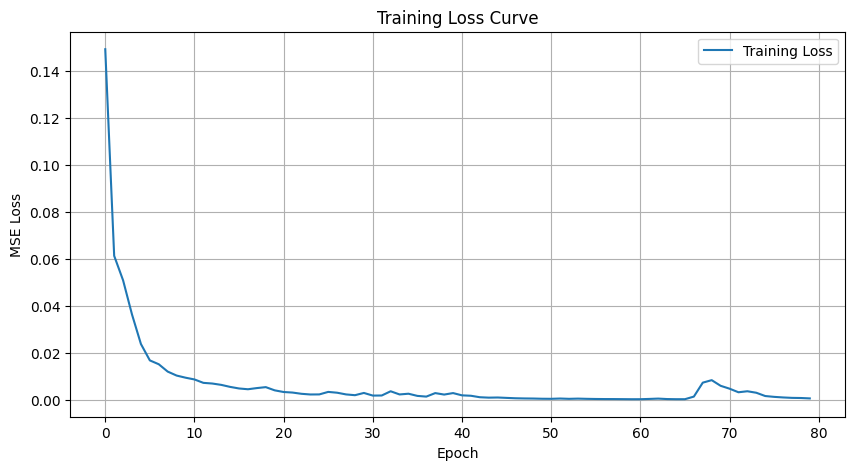


Test Loss: 0.0027


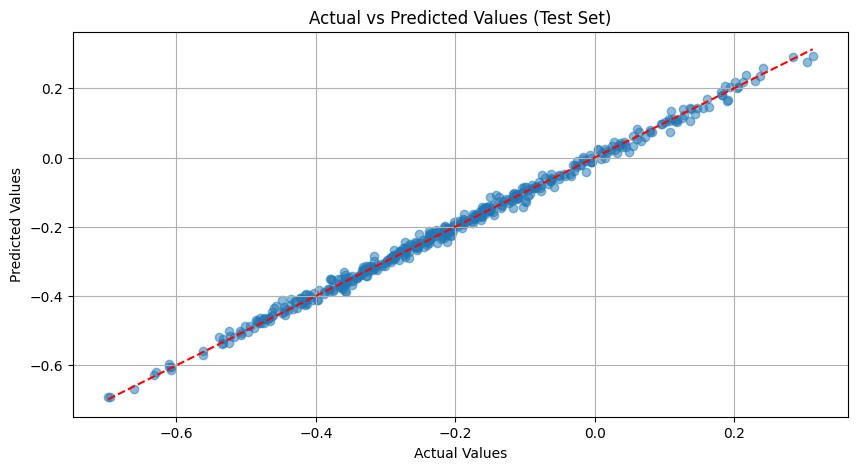

The KAN implementation doesn't have built-in plotting for splines


<Figure size 1500x500 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
X_train_tensor = torch.FloatTensor(X_train_sioux)
y_train_tensor = torch.FloatTensor(y_train_sioux)
X_test_tensor = torch.FloatTensor(X_test_sioux)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

model_kan_3 = KAN(
    layers_hidden=[X_sioux.shape[1], X_sioux.shape[1] + 20, y_sioux.shape[1]],
    spline_order=5,
    grid_eps=0.02
)

optimizer = optim.AdamW(model_kan_3.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
train_losses = []

for epoch in range(80):
    model_kan_3.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_kan_3(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    epoch_loss = total_loss/len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

model_kan_3.eval()
with torch.no_grad():
    test_preds = model_kan_3(X_test_tensor)
    test_loss = criterion(test_preds, torch.FloatTensor(y_test_sioux))
    print(f"\nTest Loss: {test_loss.item():.4f}")

    # Plot actual vs predicted for test set (for first output dimension if multi-output)
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_sioux[:, 0], test_preds.numpy()[:, 0], alpha=0.5)
    plt.plot([min(y_test_sioux[:, 0]), max(y_test_sioux[:, 0])], 
             [min(y_test_sioux[:, 0]), max(y_test_sioux[:, 0])], 
             'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values (Test Set)')
    plt.grid(True)
    plt.show()

# You can also visualize the learned splines (if your KAN implementation supports it)
try:
    plt.figure(figsize=(15, 5))
    model_kan_3.plot()
    plt.show()
except:
    print("The KAN implementation doesn't have built-in plotting for splines")

In [ ]:
device = 'cpu'

In [ ]:
X_train_tensor = torch.FloatTensor(X_train_ema).to(device)
y_train_tensor = torch.FloatTensor(y_train_ema).to(device)
X_test_tensor = torch.FloatTensor(X_test_ema).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

model_kan_ema = KAN(
    layers_hidden=[X_ema.shape[1], X_ema.shape[1], y_ema.shape[1]],
    spline_order=5,
    grid_eps=0.02
)

optimizer = optim.AdamW(model_kan_ema.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

train_losses_ema = []

for epoch in range(80):
    model_kan_ema.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_kan_ema(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    epoch_loss = total_loss/len(train_loader)
    train_losses_ema.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 0.6104
Epoch 2, Loss: 0.2863
Epoch 3, Loss: 0.1933
Epoch 4, Loss: 0.1199
Epoch 5, Loss: 0.0920
Epoch 6, Loss: 0.0896
Epoch 7, Loss: 0.0886
Epoch 8, Loss: 0.0882
Epoch 9, Loss: 0.0901
Epoch 10, Loss: 0.0960
Epoch 11, Loss: 0.1005
Epoch 12, Loss: 0.0943
Epoch 13, Loss: 0.0913
Epoch 14, Loss: 0.0891
Epoch 15, Loss: 0.0878
Epoch 16, Loss: 0.0871
Epoch 17, Loss: 0.0876
Epoch 18, Loss: 0.0851
Epoch 19, Loss: 0.0849
Epoch 20, Loss: 0.0843
Epoch 21, Loss: 0.0851
Epoch 22, Loss: 0.0848
Epoch 23, Loss: 0.0826
Epoch 24, Loss: 0.0813
Epoch 25, Loss: 0.0813
Epoch 26, Loss: 0.0804
Epoch 27, Loss: 0.0801
Epoch 28, Loss: 0.0781
Epoch 29, Loss: 0.0756
Epoch 30, Loss: 0.0734
Epoch 31, Loss: 0.0702
Epoch 32, Loss: 0.0673
Epoch 33, Loss: 0.0654
Epoch 34, Loss: 0.0641
Epoch 35, Loss: 0.0635
Epoch 36, Loss: 0.0636
Epoch 37, Loss: 0.0632
Epoch 38, Loss: 0.0618


KeyboardInterrupt: 

In [ ]:
train_losses_ema

[0.6103748284253973,
 0.2862558346965709,
 0.19331258050965758,
 0.11987266115607305,
 0.09198978316868152,
 0.08960798627601496,
 0.08861260718991816,
 0.08823054549761458,
 0.09011326935603003,
 0.09600955016200197,
 0.10045605087027533,
 0.09425892428142864,
 0.09132835590165411,
 0.08909387749623073,
 0.08779812048686267,
 0.08705473596447348,
 0.08759000936898241,
 0.08505345354442462,
 0.08485088747508113,
 0.08428954483131638,
 0.0851018202389087,
 0.08484188309301335,
 0.08261155647755512,
 0.08125742948729242,
 0.08130851980338248,
 0.0804220056786554,
 0.08009739649274746,
 0.07808616138705095,
 0.07564425526364532,
 0.07343713789125213,
 0.0702250448216819,
 0.06725407103504394,
 0.0654036292523251,
 0.06413883236714049,
 0.06352913008456516,
 0.06355442409485894,
 0.06315146522208154,
 0.06181133283111316]

In [ ]:
model_kan_ema.eval()
with torch.no_grad():
    y_pred_scaled = model_kan_ema(X_test_tensor).numpy()

y_pred = scaler_y_ema.inverse_transform(y_pred_scaled)
y_true = scaler_y_ema.inverse_transform(y_test_ema)

metrics_ema = evaluate(y_true, y_pred)

In [ ]:
metrics_ema

{'MSE': np.float64(10316.898862181979),
 'RMSE': np.float64(101.57213624898306),
 'MAE': np.float64(53.25271578440195),
 'R2': np.float64(0.9931153286538413),
 'MAPE': np.float64(0.15215175533558292),
 'MedianAE': np.float64(52.39664461313049)}

In [ ]:
metrics_ema

{'MSE': np.float64(19044.54737550493),
 'RMSE': np.float64(138.00198323033234),
 'MAE': np.float64(79.26058542933453),
 'R2': np.float64(0.9873042398206402),
 'MAPE': np.float64(0.1986593529420532),
 'MedianAE': np.float64(78.96154025328104)}

: 